### LABORATORIO 2
Ignacio Méndez Alvarez (22613) y Diego Soto Flores (22737)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.tsa as tsa
import statsmodels as sm
from datetime import datetime
import os
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.metrics import mean_squared_error

In [2]:
importacion = pd.read_excel("Datos.xlsx", sheet_name= "IMPORTACION", header=6) 
importacion = importacion.iloc[:288].reset_index(drop=True)

consumo = pd.read_excel("Datos.xlsx", sheet_name= "CONSUMO", header=6) 
consumo = consumo.iloc[:300].reset_index(drop= True)

In [3]:
importaciones = importacion[["Fecha", "Gasolina regular", "Gasolina superior", "Diesel alto azufre"]]
consumos = consumo[["Fecha", "Gasolina regular", "Gasolina superior", "Diesel alto azufre"]]

importaciones["Fecha"] = pd.to_datetime(importaciones["Fecha"])
consumos["Fecha"] = pd.to_datetime(consumos["Fecha"])
consumos.dtypes

C:\Users\dfsf2\AppData\Local\Temp\ipykernel_13168\2987316155.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  importaciones["Fecha"] = pd.to_datetime(importaciones["Fecha"])
C:\Users\dfsf2\AppData\Local\Temp\ipykernel_13168\2987316155.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  consumos["Fecha"] = pd.to_datetime(consumos["Fecha"])


Fecha                 datetime64[ns]
Gasolina regular             float64
Gasolina superior            float64
Diesel alto azufre           float64
dtype: object

In [4]:
consumos.set_index('Fecha', inplace=True)

In [5]:
consumos.head()

,Gasolina regular,Gasolina superior,Diesel alto azufre
Fecha,,,
2000-01-01,202645.20,308156.82,634667.06
2000-02-01,205530.96,307766.31,642380.66
2000-03-01,229499.56,331910.29,699807.25
2000-04-01,210680.40,315648.08,586803.98
2000-05-01,208164.34,319667.97,656948.20


In [6]:
def prediccion_fun(data, modelo, batch_size, scaler, dif=False, dif_cant=1, Series=None, n=1):
    prediccion = [0] * len(data)
    for i, X in enumerate(data):
        # Reformatear a (1, lags, 1)
        X = np.reshape(X, (1, X.shape[0], 1))
        
        # Hacer predicción
        yhat = modelo.predict(X, batch_size=batch_size, verbose=0)
        
        # Invertir el escalado
        yhat = scaler.inverse_transform(yhat)
        
        # Invertir la diferenciación si aplica
        if dif and Series is not None:
            yhat = yhat + Series[n + dif_cant * i]
        
        # Guardar predicción
        prediccion[i] = yhat[0][0]
    
    return prediccion

def supervisada(serie,retrasos):
    serie_x = []
    serie_y = []
    for i in range(len(serie)-retrasos):
        valor = serie[i:(i+retrasos),0]
        valor_sig = serie[i+retrasos,0]
        serie_x.append(valor)
        serie_y.append(valor_sig)
    return np.array(serie_x), np.array(serie_y)

### **Modelos consumo**
##### **Gasolina Regular**

In [7]:
regular_c = consumos[["Gasolina regular"]]

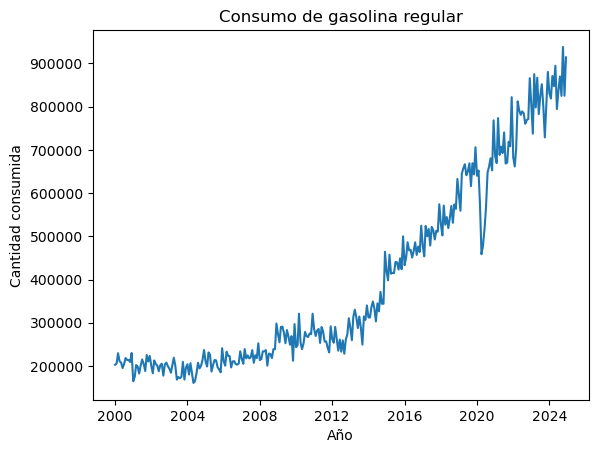

In [8]:
plt.plot(regular_c)
plt.gca().set(title="Consumo de gasolina regular", xlabel="Año", ylabel="Cantidad consumida")
plt.show()

Como se puede observar la serie de tiempo no estacionaria en media, para esto vamos a diferenciar la serie de tiempo para hacer la serie estacionaria en media.

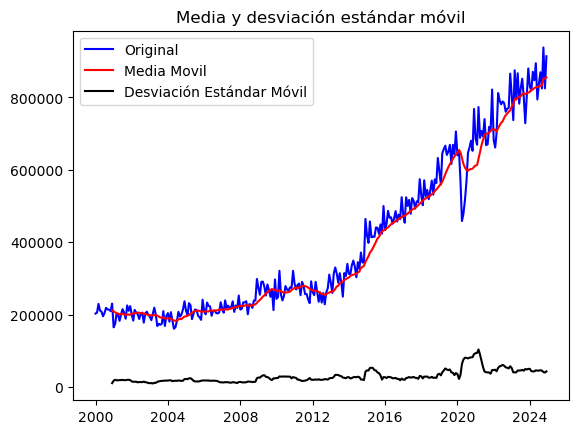

In [9]:
mediaMovil = regular_c.rolling(window=12).mean()
deMovil = regular_c.rolling(window=12).std()
# Se grafican los resultados.
original = plt.plot(regular_c, color="blue", label="Original")
media = plt.plot(mediaMovil, color='red', label = 'Media Movil')
ds = plt.plot(deMovil,color='black', label = 'Desviación Estándar Móvil')
plt.legend(loc = 'best')
plt.title('Media y desviación estándar móvil')
plt.show(block=False)

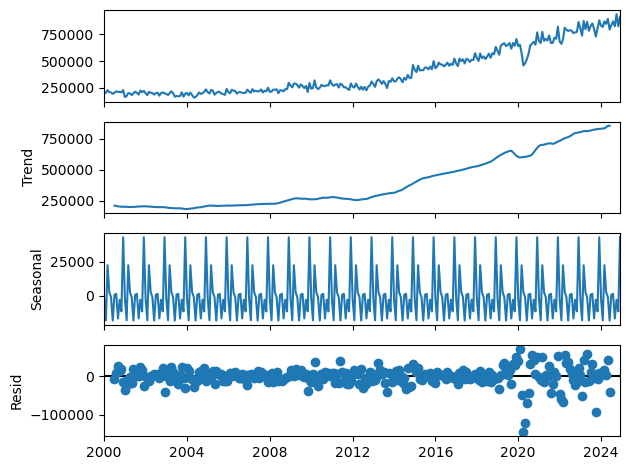

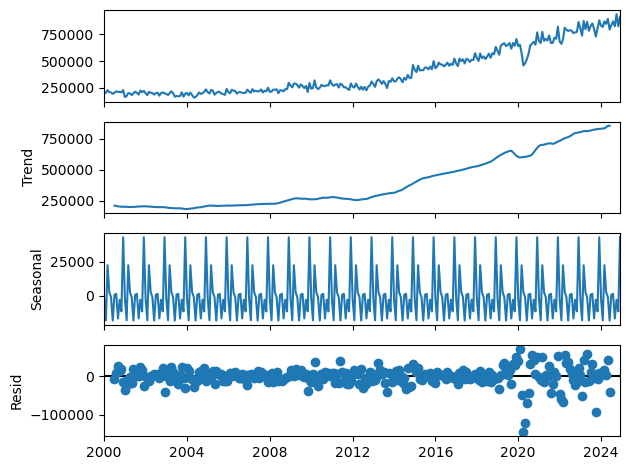

In [10]:
descomposicion = seasonal_decompose(regular_c)
descomposicion.plot()

En este gráfico se puede observar que hay tendencia por lo que la serie no parece ser estacionaria en media y tampoco en varianza.

In [11]:
print('Resultados del Test de Dickey Fuller')
dfTest = adfuller(regular_c, autolag='AIC')
salidaDf = pd.Series(dfTest[0:4], index=['Estadístico de prueba','p-value','# de retardos usados','# de observaciones usadas'])
for key,value in dfTest[4].items():
        salidaDf['Critical Value (%s)'%key] = value
print(salidaDf)

Resultados del Test de Dickey Fuller
Estadístico de prueba          2.478789
p-value                        0.999043
# de retardos usados          14.000000
# de observaciones usadas    285.000000
Critical Value (1%)           -3.453505
Critical Value (5%)           -2.871735
Critical Value (10%)          -2.572202
dtype: float64


El p-value es mayor a 0.05 por lo que no se puede rechazar la hipótesis nula de que existen raices unitarias, es decir, tiene una tendencia o depende mucho de su valor pasado (no es estacionaria). 

Como la serie no es estacionaria en media, vamos a probar con una diferenciación

In [12]:
print('Resultados del Test de Dickey Fuller para una diferenciación de la serie')
regular_c_diff = regular_c.diff()
regular_c_diff.fillna(0,inplace=True)
dfTest = adfuller(regular_c_diff)
salidaDf = pd.Series(dfTest[0:4], index=['Estadístico de prueba','p-value','# de retardos usados','# de observaciones usadas'])
for key,value in dfTest[4].items():
        salidaDf['Critical Value (%s)'%key] = value
print(salidaDf)

Resultados del Test de Dickey Fuller para una diferenciación de la serie
Estadístico de prueba         -4.372644
p-value                        0.000332
# de retardos usados          16.000000
# de observaciones usadas    283.000000
Critical Value (1%)           -3.453670
Critical Value (5%)           -2.871808
Critical Value (10%)          -2.572241
dtype: float64


Ya que el valor p es menor a 0.05, se puede indicar que la serie es estacionaria en media.

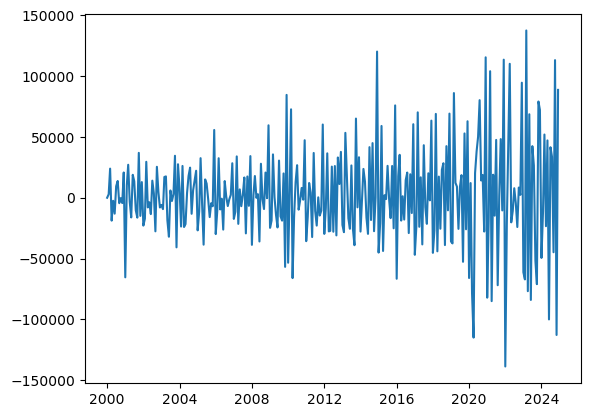

In [13]:
plt.plot(regular_c_diff)

In [14]:
scaler = StandardScaler()
regular_c_scaled = scaler.fit_transform(regular_c_diff) 
regular_c_scaled[1:7]

array([[ 0.01283202],
       [ 0.53837341],
       [-0.52821624],
       [-0.12182156],
       [-0.38504394],
       [ 0.17691121]])

In [15]:
total_len = len(regular_c_scaled)

# Definir proporciones
traincr_prop = 0.6
valcr_prop = 0.2
testcr_prop = 0.2 

# Calcular índices
traincr_end = int(traincr_prop * total_len)
valcr_end = traincr_end + int(valcr_prop * total_len)

# Separar sin solapamientos
traincr= regular_c_scaled[:traincr_end]
validation = regular_c_scaled[traincr_end:valcr_end]
testcr = regular_c_scaled[valcr_end:]

# Si hace falta, redimensionar (por ejemplo para un LSTM univariante)
traincr = traincr.reshape(-1, 1)
validation = validation.reshape(-1, 1)
testcr = testcr.reshape(-1, 1)

# Verificar tamaños
print(f"Total registros: {total_len}")
print(f"Train: {len(traincr)} | Validation: {len(validation)} | Test: {len(testcr)}")

Total registros: 300
Train: 180 | Validation: 60 | Test: 60


In [16]:
traincr, type(traincr)

(array([[-5.91026109e-02],
        [ 1.28320202e-02],
        [ 5.38373409e-01],
        [-5.28216235e-01],
        [-1.21821565e-01],
        [-3.85043944e-01],
        [ 1.76911211e-01],
        [ 2.85687363e-01],
        [-1.70816214e-01],
        [-6.65885727e-02],
        [-1.68264142e-01],
        [ 4.59219291e-01],
        [-1.69118607e+00],
        [ 1.97437219e-01],
        [ 6.17773312e-01],
        [-1.41594016e-01],
        [-4.62411264e-01],
        [ 4.11412684e-01],
        [ 2.79929621e-01],
        [-3.16689643e-01],
        [-4.66776558e-01],
        [ 8.61931679e-01],
        [-4.30920419e-01],
        [ 2.62087551e-01],
        [-6.29943653e-01],
        [-4.87618148e-01],
        [ 6.78559641e-01],
        [-2.57178353e-01],
        [-1.50888215e-01],
        [-3.94478734e-01],
        [ 2.91457568e-01],
        [ 2.93432136e-02],
        [-7.47747530e-01],
        [ 5.76109576e-01],
        [ 5.38827901e-02],
        [-2.58784927e-01],
        [-2.06315433e-01],
 

In [17]:
x_train,y_train = supervisada(traincr,1)
x_val,y_val = supervisada(validation,1)
x_test,y_test = supervisada(testcr,1)

In [18]:
x_train


array([[-5.91026109e-02],
       [ 1.28320202e-02],
       [ 5.38373409e-01],
       [-5.28216235e-01],
       [-1.21821565e-01],
       [-3.85043944e-01],
       [ 1.76911211e-01],
       [ 2.85687363e-01],
       [-1.70816214e-01],
       [-6.65885727e-02],
       [-1.68264142e-01],
       [ 4.59219291e-01],
       [-1.69118607e+00],
       [ 1.97437219e-01],
       [ 6.17773312e-01],
       [-1.41594016e-01],
       [-4.62411264e-01],
       [ 4.11412684e-01],
       [ 2.79929621e-01],
       [-3.16689643e-01],
       [-4.66776558e-01],
       [ 8.61931679e-01],
       [-4.30920419e-01],
       [ 2.62087551e-01],
       [-6.29943653e-01],
       [-4.87618148e-01],
       [ 6.78559641e-01],
       [-2.57178353e-01],
       [-1.50888215e-01],
       [-3.94478734e-01],
       [ 2.91457568e-01],
       [ 2.93432136e-02],
       [-7.47747530e-01],
       [ 5.76109576e-01],
       [ 5.38827901e-02],
       [-2.58784927e-01],
       [-2.06315433e-01],
       [-2.92398842e-01],
       [ 3.6

In [19]:
y_train, type(y_train)

(array([ 1.28320202e-02,  5.38373409e-01, -5.28216235e-01, -1.21821565e-01,
        -3.85043944e-01,  1.76911211e-01,  2.85687363e-01, -1.70816214e-01,
        -6.65885727e-02, -1.68264142e-01,  4.59219291e-01, -1.69118607e+00,
         1.97437219e-01,  6.17773312e-01, -1.41594016e-01, -4.62411264e-01,
         4.11412684e-01,  2.79929621e-01, -3.16689643e-01, -4.66776558e-01,
         8.61931679e-01, -4.30920419e-01,  2.62087551e-01, -6.29943653e-01,
        -4.87618148e-01,  6.78559641e-01, -2.57178353e-01, -1.50888215e-01,
        -3.94478734e-01,  2.91457568e-01,  2.93432136e-02, -7.47747530e-01,
         5.76109576e-01,  5.38827901e-02, -2.58784927e-01, -2.06315433e-01,
        -2.92398842e-01,  3.66876558e-01,  3.78646863e-01, -5.22681656e-01,
        -8.58761668e-01,  9.02090609e-02, -1.25223164e-01,  1.79954917e-02,
         8.02302731e-01, -1.07625340e+00,  6.28196724e-01,  1.37664191e-01,
        -6.49517433e-01,  5.93133527e-01, -6.59248361e-01, -5.98483220e-01,
         4.1

In [20]:
(x_train.shape[0],1,1)

(179, 1, 1)

In [21]:
x_train = np.reshape(x_train,(x_train.shape[0],1,1))
x_val = np.reshape(x_val, (x_val.shape[0],1,1))
x_test = np.reshape(x_test, (x_test.shape[0],1,1))
len(x_val)

59

In [22]:
unidades =  10
paso = 1 # lags, 1 lag es un mes. 
caracteristicas = 1 # es univariada
lote = 1


modelo1cr = Sequential()
modelo1cr.add(LSTM(
    units=unidades, 
    input_shape=(paso, caracteristicas), 
    stateful=False  # desactivamos estado entre batches
))

# modelo1.add(LSTM(
#     units=unidades, 
#     batch_input_shape=(lote, paso, caracteristicas), 
#     stateful=True  # activamos estado entre batches
# ))
modelo1cr.add(Dense(1))
modelo1cr.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 10)                480       
                                                                 
 dense (Dense)               (None, 1)                 11        
                                                                 
Total params: 491 (1.92 KB)
Trainable params: 491 (1.92 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [23]:
modelo1cr.compile(loss='mean_squared_error',optimizer="rmsprop")

In [24]:
epocas = 50
history= modelo1cr.fit(
    x = x_train,
    y = y_train,
    batch_size = lote,
    epochs = epocas,
    shuffle = False,
    validation_data = (x_val,y_val),
    verbose=1
)

Epoch 1/50
179/179 [==============================] - 2s 5ms/step - loss: 0.4605 - val_loss: 0.8393
Epoch 2/50
179/179 [==============================] - 0s 2ms/step - loss: 0.4305 - val_loss: 0.7694
Epoch 3/50
179/179 [==============================] - 0s 2ms/step - loss: 0.4114 - val_loss: 0.7210
Epoch 4/50
179/179 [==============================] - 0s 2ms/step - loss: 0.3996 - val_loss: 0.6878
Epoch 5/50
179/179 [==============================] - 0s 2ms/step - loss: 0.3925 - val_loss: 0.6653
Epoch 6/50
179/179 [==============================] - 0s 2ms/step - loss: 0.3884 - val_loss: 0.6504
Epoch 7/50
179/179 [==============================] - 0s 2ms/step - loss: 0.3861 - val_loss: 0.6407
Epoch 8/50
179/179 [==============================] - 0s 2ms/step - loss: 0.3847 - val_loss: 0.6344
Epoch 9/50
179/179 [==============================] - 0s 2ms/step - loss: 0.3838 - val_loss: 0.6303
Epoch 10/50
179/179 [==============================] - 0s 2ms/step - loss: 0.3832 - val_loss: 0.6276

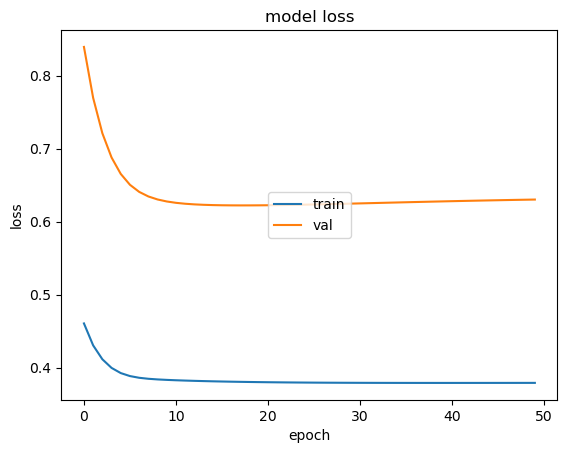

In [25]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='center')

In [26]:
print("Pérdida en Train")
modelo1cr.evaluate(
    x = x_train,
    y = y_train
)
print("Pérdida en Validación")
modelo1cr.evaluate(
    x = x_val,
    y = y_val
)
print("Pérdida en Test")
modelo1cr.evaluate(
    x = x_test,
    y = y_test
)

Pérdida en Train
6/6 [==============================] - 1s 2ms/step - loss: 0.3769
Pérdida en Validación
2/2 [==============================] - 0s 4ms/step - loss: 0.6302
Pérdida en Test
2/2 [==============================] - 0s 4ms/step - loss: 2.2066


2.2065610885620117

In [27]:
prediccion_val = []

prediccion_val = prediccion_fun(x_val,modelo1cr, 1,scaler,dif=True,dif_cant=1, Series = regular_c.values , n=traincr_end)
prediccion_test = prediccion_fun(x_test,modelo1cr, 1,scaler,dif=True,dif_cant=1, Series = regular_c.values , n = len(regular_c.values) - len(x_test))

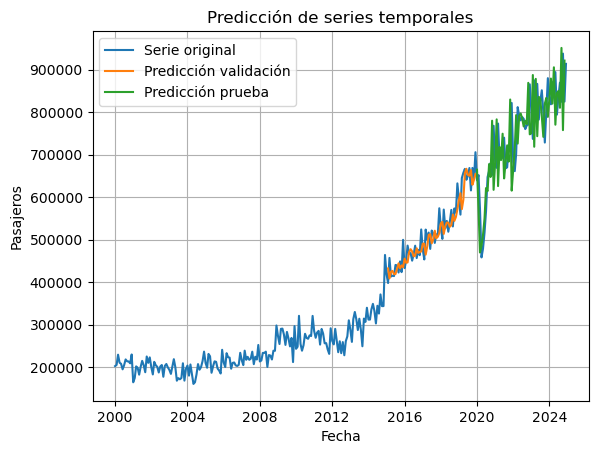

In [28]:
df_val = pd.DataFrame(prediccion_val, index=regular_c[traincr_end+1:valcr_end].index)
df_test = pd.DataFrame(prediccion_test, index=regular_c[valcr_end:].index[:len(prediccion_test)])


plt.plot(regular_c, label='Serie original')
plt.plot(df_val, label='Predicción validación')
plt.plot(df_test, label='Predicción prueba')

plt.legend()
plt.title('Predicción de series temporales')
plt.xlabel('Fecha')
plt.ylabel('Pasajeros')
plt.grid(True)
plt.show()


In [29]:

# Valores reales y predichos
y_true = regular_c[valcr_end:].iloc[:len(prediccion_test)]
y_pred = prediccion_test  

mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)

if isinstance(y_true, pd.DataFrame):
    promedio = y_true.iloc[:, 0].mean() 
else:
    promedio = y_true.mean()

# Calcular error relativo
error_relativo = (rmse / promedio) * 100

# Mostrar resultados
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"Error relativo: {error_relativo:.2f}%")


MSE: 6877720091.40
RMSE: 82932.02
Error relativo: 11.09%


#### Tuneo de Modelo 1 (Consumo Regular)

In [ ]:
x_train,y_train = supervisada(traincr,3)
x_val,y_val = supervisada(validation,3)
x_test,y_test = supervisada(testcr,3)

In [ ]:
unidades =  10
paso = 3 # lags, 3 lag es un mes. 
caracteristicas = 1 # es univariada
lote = 1


modelo2cr = Sequential()
modelo2cr.add(LSTM(
    units=unidades, 
    input_shape=(paso, caracteristicas), 
    stateful=False  # desactivamos estado entre batches
))

# modelo1.add(LSTM(
#     units=unidades, 
#     batch_input_shape=(lote, paso, caracteristicas), 
#     stateful=True  # activamos estado entre batches
# ))
modelo2cr.add(Dense(1))
modelo2cr.summary()

In [ ]:
modelo2cr.compile(loss='mean_squared_error',optimizer="rmsprop")

In [ ]:
epocas = 50
history= modelo2cr.fit(
    x = x_train,
    y = y_train,
    batch_size = lote,
    epochs = epocas,
    shuffle = False,
    validation_data = (x_val,y_val),
    verbose=1
)

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='center')

In [ ]:
print("Pérdida en Train")
modelo2cr.evaluate(
    x = x_train,
    y = y_train
)
print("Pérdida en Validación")
modelo2cr.evaluate(
    x = x_val,
    y = y_val
)
print("Pérdida en Test")
modelo2cr.evaluate(
    x = x_test,
    y = y_test
)

In [ ]:
prediccion_val = []

prediccion_val = prediccion_fun(x_val,modelo2cr, 1,scaler,dif=True,dif_cant=1, Series = regular_c.values , n=traincr_end)
prediccion_test = prediccion_fun(x_test,modelo2cr, 1,scaler,dif=True,dif_cant=1, Series = regular_c.values , n = len(regular_c.values) - len(x_test))

In [ ]:
lags = 3  # o el valor que estés usando realmente

# Obtener solo los índices que correspondan exactamente a la cantidad de predicciones
index_val = regular_c.index[traincr_end+1+lags : traincr_end+1+lags + len(prediccion_val)]
index_test = regular_c.index[valcr_end+lags : valcr_end+lags + len(prediccion_test)]

df_val = pd.DataFrame(prediccion_val, index=index_val, columns=['Predicción validación'])
df_test = pd.DataFrame(prediccion_test, index=index_test, columns=['Predicción prueba'])




plt.plot(regular_c, label='Serie original')
plt.plot(df_val, label='Predicción validación')
plt.plot(df_test, label='Predicción prueba')

plt.legend()
plt.title('Predicción de series temporales')
plt.xlabel('Fecha')
plt.ylabel('Pasajeros')
plt.grid(True)
plt.show()

In [ ]:
# Valores reales y predichos
y_true = regular_c[valcr_end:].iloc[:len(prediccion_test)]
y_pred = prediccion_test  # o df_test.values.flatten()

# Calcular MSE y RMSE
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)

# Calcular promedio correctamente, ya sea Serie o DataFrame
if isinstance(y_true, pd.DataFrame):
    promedio = y_true.iloc[:, 0].mean()  # toma la primera columna
else:
    promedio = y_true.mean()

# Calcular error relativo
error_relativo = (rmse / promedio) * 100

# Mostrar resultados
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"Error relativo: {error_relativo:.2f}%")